In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas as pd
import random
import torch
import time
import numpy as np
from gensim.models.word2vec import Word2Vec
from model import BatchProgramClassifier
from torch.autograd import Variable
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.autograd import Variable

import re

from pycparser.c_ast import TypeDecl, ArrayDecl
from pycparser import c_ast

In [2]:
root = '/home/david/projects/university/astnn/data/'

word2vec = Word2Vec.load(root+"train/embedding/node_w2v_128").wv
embeddings = np.zeros((word2vec.vectors.shape[0] + 1, word2vec.vectors.shape[1]), dtype="float32")
embeddings[:word2vec.vectors.shape[0]] = word2vec.vectors

HIDDEN_DIM = 100
ENCODE_DIM = 128
LABELS = 104
EPOCHS = 15
BATCH_SIZE = 1
USE_GPU = False
MAX_TOKENS = word2vec.vectors.shape[0]
EMBEDDING_DIM = word2vec.vectors.shape[1]

model = BatchProgramClassifier(EMBEDDING_DIM,HIDDEN_DIM,MAX_TOKENS+1,ENCODE_DIM,LABELS,BATCH_SIZE,
                               USE_GPU, embeddings)
model.load_state_dict(torch.load("/home/david/projects/university/astnn/model.pt"))

<All keys matched successfully>

# Load Data

In [3]:
word2vec = Word2Vec.load('/home/david/projects/university/astnn/data/train/embedding/node_w2v_128').wv
vocab = word2vec.vocab

ast_data = pd.read_pickle(root+'test/test_.pkl')
block_data = pd.read_pickle(root+'test/blocks.pkl')

# Allowed var names

In [4]:
leaf_embed = nn.Sequential(
    model._modules['encoder']._modules['embedding'],
    model._modules['encoder']._modules['W_c']
)

In [5]:
# words we wont allow as variable names
reserved_words = [
    'auto',
    'break',
    'case',
    'char',
    'const',
    'continue',
    'default',
    'do',
    'int',
    'long',
    'register',
    'return',
    'short',
    'sizeof',
    'static',
    'struct',
    'switch',
    'typedef',
    'union',
    'unsigned',
    'void',
    'volatile',
    'while',
    'double',
    'else',
    'enum',
    'extern',
    'float',
    'for',
    'goto',
    'if',
    'printf',
    'scanf',
    'cos',
    'malloc'
]


def allowed_variable(var):
    pattern = re.compile("([a-z]|[A-Z]|_)+([a-z]|[A-Z]|[0-9]|_)*$")
    if (var not in reserved_words) and pattern.match(var):
        return True
    else:
        return False

allowed_variable('scanf')

False

In [6]:
embedding_map = {}

for index in range(len(vocab)):
    if allowed_variable(word2vec.index2word[index]):
        embedding_map[index] = leaf_embed(torch.tensor(index)).detach().numpy()

In [7]:
embedding_map

{0: array([ 0.03019059,  0.1367945 , -0.10109228,  0.08461949, -0.13135529,
         0.00557616,  0.10584277,  0.12694216, -0.01418607, -0.09883386,
        -0.06054131,  0.1835562 , -0.07038593, -0.08064822, -0.04285896,
         0.06592396,  0.02370179, -0.11163816,  0.19224797, -0.20805568,
         0.11814766, -0.09550146,  0.21219593,  0.17018655,  0.02565401,
        -0.04904985,  0.07065259,  0.09362197,  0.18712063,  0.07780752,
         0.00451265,  0.07356361, -0.00931085, -0.10410995,  0.13752632,
        -0.00488425, -0.2059317 , -0.05644508, -0.09728245, -0.0601282 ,
        -0.12878302,  0.15677568, -0.33194137, -0.04986588,  0.05462546,
         0.07078095, -0.19046427,  0.2693159 , -0.02590631,  0.04506591,
         0.05695089,  0.12227046, -0.1137234 , -0.0282506 ,  0.08076112,
        -0.13223892, -0.008921  , -0.15481322,  0.04438758, -0.0807694 ,
        -0.2915518 ,  0.0683229 , -0.04187719,  0.01936601,  0.11482322,
         0.1755356 ,  0.00554226,  0.21991403,  

# Var replace functions

In [8]:
def replace_index(node, old_i, new_i):
    i = node[0]
    if i == old_i:
        result = [new_i]
    else:
        result = [i]
    children = node[1:]
    for child in children:
        result.append(replace_index(child, old_i, new_i))
    return result

def replace_var(x, old_i, new_i):
    mod_blocks = []
    for block in x:
        mod_blocks.append(replace_index(block, old_i, new_i))

    return mod_blocks

# Closest Var functions

In [9]:
def l2_norm(a, b):
    return np.linalg.norm(a-b)

def cos_sim(a, b):
    return np.inner(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def closest_index(embedding, embedding_map, metric):
    closest_i = 0
#     closest_dist = l2_norm(embedding_map[closest_i], embedding)
    closest_dist = metric(embedding_map[closest_i], embedding)
    for i, e in embedding_map.items():
#         d = l2_norm(embedding_map[i], embedding)
        d = metric(embedding_map[i], embedding)
        if d < closest_dist:
            closest_dist = d
            closest_i = i
    return closest_i

def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0:
        return v
    return v / norm

# Grad locating functions

In [10]:
def get_embedding(indices, node_list):
    '''
    get the embeddings at the index positions in postorder traversal.
    '''
    res = []
    c = 0
    for i in range(node_list.size(0)):
        if not np.all(node_list[i].detach().numpy() == 0):
            if c in indices:
                res.append(node_list[i])
            c += 1
    return res

def post_order_loc(node, var, res, counter):
    '''
    
    '''
    index = node[0]
    children = node[1:]
    for child in children:
        res, counter = post_order_loc(child, var, res, counter)
    if var == index and (not children):
        res.append(counter) 
#         print(counter, word2vec.index2word[index])
    counter += 1
    return res, counter

def get_grad(x, var_index, node_list):
    grads = []
    for i, block in enumerate(x):
        indices, _ = post_order_loc(block, var_index, [], 0)
        grads += get_embedding(indices, node_list.grad[:, i, :])
        try:
            node_embedding = get_embedding(indices, node_list[:, i, :])[0]
        except:
            pass
        
    if len(grads) < 1:
        return None, None
    grad = torch.stack(grads).sum(dim=0)
    return grad, node_embedding

# Var name finder

In [11]:

class declarationFinder(c_ast.NodeVisitor):
    def __init__(self):
        self.names = set()
    
    def visit_Decl(self, node):
        if type(node.type) in [TypeDecl, ArrayDecl] :
            self.names.add(node.name)

def get_var_names(ast):
    declaration_finder = declarationFinder()
    declaration_finder.visit(ast)
    return declaration_finder.names
    
# get_var_names(x)

# FGSM

In [24]:
def gradient_method(x, n_list, var, epsilon, metric):

    orig_index = vocab[var].index if var in vocab else MAX_TOKEN

    grad, node_embedding = get_grad(x, orig_index, n_list)
    if grad is None:
#         print("no leaf occurences")
        return None, None

    v = node_embedding.detach().numpy()
    embedding_magnitude = np.linalg.norm(v)

#     g = torch.sign(grad).detach().numpy()
    g = grad.detach().numpy()

    diff = epsilon * g
    v = v + diff
    diff_magnitude = np.linalg.norm(diff)
    
    
    # get the closest emebedding from our map
    i = closest_index(v, embedding_map, metric)
#         print("orig name:", word2vec.index2word[orig_index], "; new name:", word2vec.index2word[i])
    if i != orig_index:
        return replace_var(x, orig_index, i), (diff_magnitude, embedding_magnitude)
    else:
        return x, (diff_magnitude, embedding_magnitude)

In [25]:
MAX_TOKEN = word2vec.vectors.shape[0]

x, ast = block_data['code'][45281], ast_data['code'][45281]

_, orig_pred = torch.max(model([x]).data, 1)
orig_pred = orig_pred.item()

# get the grad
loss_function = torch.nn.CrossEntropyLoss()
labels = torch.LongTensor([orig_pred])
output = model([x])
loss = loss_function(output, Variable(labels))
loss.backward()
n_list = model._modules['encoder'].node_list

new_x_l2, d_mag = gradient_method(x, n_list, 'n', 1, l2_norm)

o = model([new_x_l2])
_, predicted_l2 = torch.max(o.data, 1)

print(orig_pred, predicted_l2.item(), d_mag)

2 2 (0.001942367, 1.4084148)


In [26]:
def evaluate(epsilon, limit = None):
    ast_count = 0
    var_count = 0

    ast_total = 0
    var_total = 0
    
    mags = []

    for code_id in block_data['id'].tolist():
    #     print(code_id)
        x, ast = block_data['code'][code_id], ast_data['code'][code_id]

        _, orig_pred = torch.max(model([x]).data, 1)
        orig_pred = orig_pred.item()

        # get the grad
        loss_function = torch.nn.CrossEntropyLoss()
        labels = torch.LongTensor([orig_pred])
        output = model([x])
        loss = loss_function(output, Variable(labels))
        loss.backward()
        n_list = model._modules['encoder'].node_list

        var_names = get_var_names(ast)
        success = False
        for var in list(var_names):

            new_x_l2, d_mag = gradient_method(x, n_list, var, epsilon, l2_norm)
            if new_x_l2:
                mags.append(d_mag)
                o = model([new_x_l2])
                _, predicted_l2 = torch.max(o.data, 1)

    #             print(orig_pred, predicted_l2.item())
                if orig_pred != predicted_l2.item():
                    var_count += 1
                    success = True
                var_total += 1

        if success:
            ast_count += 1
        ast_total += 1


        if ast_total % 1000 == 999:
            print(ast_total, "AST level success:", ast_count / ast_total)
            print("variable level success:", var_count / var_total)
    
        if limit and limit < ast_total:
            break
    return (1-(ast_count / ast_total), 1-(var_count / var_total), mags)



In [21]:
def evaluate_steps(epsilon, depth, limit = None):
    ast_count = 0
    var_count = 0

    ast_total = 0
    var_total = 0
    
    mags = []

    for code_id in block_data['id'].tolist():
    #     print(code_id)
        x, ast = block_data['code'][code_id], ast_data['code'][code_id]

        _, orig_pred = torch.max(model([x]).data, 1)
        orig_pred = orig_pred.item()

        var_names = get_var_names(ast)
        success = False
        for var in list(var_names):
            
            x_tmp = x
            
            for d in range(depth):
#                 print(d)
            # get the grad
#                 if x == x_tmp:
#                     print("true")
#                 else:
#                     print("false")
                loss_function = torch.nn.CrossEntropyLoss()
                labels = torch.LongTensor([orig_pred])
                output = model([x_tmp])
                loss = loss_function(output, Variable(labels))
                loss.backward()
                n_list = model._modules['encoder'].node_list

                x_new, d_mag = gradient_method(x_tmp, n_list, var, epsilon, l2_norm)
                if x_new:
                    x_tmp = x_new
#                     print(d_mag)
#                 mags.append(d_mag)
                
                    o = model([x_tmp])
                    _, predicted = torch.max(o.data, 1)

        #             print(orig_pred, predicted_l2.item())
                    if orig_pred != predicted.item():
    #                     print(orig_pred, predicted.item())
                        var_count += 1
                        success = True
                        break
            var_total += 1

        if success:
            ast_count += 1
        ast_total += 1


#         if ast_total % 100 == 99:
#         print(ast_total, "AST robustness:", 1-(ast_count / ast_total))
#         print("variable robustness:", 1-(var_count / var_total))
    
        if limit and limit < ast_total:
            break
    return (1-(ast_count / ast_total), 1-(var_count / var_total), mags)



In [29]:
import time

epsilons = np.linspace(1,5000,20)
ast_performances = []
var_performances = []
magintude_info = []
# e = 10

for e in epsilons:
    start = time.time()
    ast_performance, var_performance, mags = evaluate(e, limit=1000)
    eval_time = time.time() - start
        
    ast_performances.append(ast_performance)
    var_performances.append(var_performance)
    magintude_info.append(mags)
    print(e, eval_time, ast_performance, var_performance)

999 AST level success: 0.018018018018018018
variable level success: 0.004339067100573377
1.0 532.6842064857483 0.982017982017982 0.9956683168316832
999 AST level success: 0.2802802802802803
variable level success: 0.11622501162250116
264.10526315789474 542.1524374485016 0.7192807192807193 0.8838180693069306
999 AST level success: 0.32232232232232233
variable level success: 0.1275375794204246
527.2105263157895 540.5549960136414 0.6773226773226773 0.8725247524752475
999 AST level success: 0.34234234234234234
variable level success: 0.13358128002479466
790.3157894736842 526.1318051815033 0.6573426573426573 0.8664913366336634
999 AST level success: 0.35835835835835833
variable level success: 0.13838524717185804
1053.421052631579 522.7787852287292 0.6413586413586414 0.8616955445544554
999 AST level success: 0.37237237237237236
variable level success: 0.14117464745079808
1316.5263157894738 520.077073097229 0.6273726273726274 0.8587561881188119
999 AST level success: 0.3833833833833834
variab

In [30]:
import pickle

pickle.dump( ast_performances, open( "ast_performances_fgm_0421.p", "wb" ) )
pickle.dump( var_performances, open( "var_performances_fgm_0421.p", "wb" ) )
pickle.dump( magintude_info, open( "magintude_info_fgm_0421.p", "wb" ) )

In [62]:
import time

epsilons = np.linspace(1,5000,6)
depths = list(range(1, 11))
ast_performances = []
var_performances = []
depths = [1, 2, 3]

for depth in depths:
    for e in epsilons:
        start = time.time()
        ast_performance, var_performance, mags = evaluate_steps(e, depth, limit=1000)
        eval_time = time.time() - start

        ast_performances.append(ast_performance)
        var_performances.append(var_performance)
    #     mean_mags.append(np.mean(mags))
        print(e, depth, eval_time, ast_performance, var_performance)

1.0 1 616.2080252170563 0.982017982017982 0.9958634953464323
1000.8 1 620.2379806041718 0.6413586413586414 0.8683705126311124
2000.6 1 615.1077892780304 0.6043956043956045 0.8598020387058649
3000.3999999999996 1 614.508082151413 0.5834165834165834 0.8558132663613532
4000.2 1 613.9550426006317 0.5704295704295704 0.8528586201802334
5000.0 1 612.1820187568665 0.5664335664335665 0.8512335647806175
1.0 2 1214.7362267971039 0.982017982017982 0.9958634953464323
1000.8 2 1064.4754254817963 0.6413586413586414 0.8683705126311124
2000.6 2 1052.1619317531586 0.6043956043956045 0.8598020387058649
3000.3999999999996 2 1036.1405475139618 0.5834165834165834 0.8558132663613532
4000.2 2 1031.0734827518463 0.5704295704295704 0.8528586201802334
5000.0 2 1025.6112248897552 0.5664335664335665 0.8512335647806175
1.0 3 1807.5911967754364 0.982017982017982 0.9958634953464323
1000.8 3 1520.2841274738312 0.6413586413586414 0.8683705126311124
2000.6 3 1488.7213051319122 0.6043956043956045 0.8598020387058649
3000.

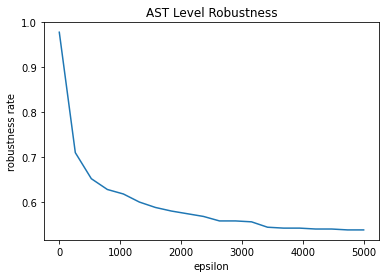

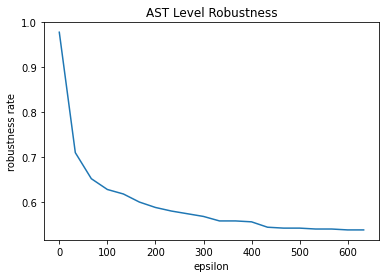

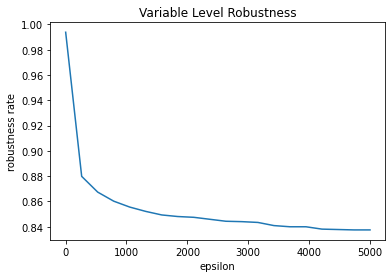

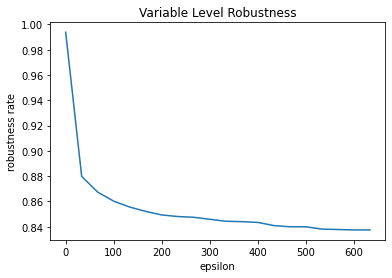

In [34]:
import matplotlib.pyplot as plt

plt.plot(depths, ast_performances)
plt.xlabel("epsilon")
plt.ylabel("robustness rate")
plt.title("AST Level Robustness")
plt.show()

# plt.plot(mean_mags, ast_performances)
# plt.xlabel("epsilon")
# plt.ylabel("robustness rate")
# plt.title("AST Level Robustness")
# plt.show()

plt.plot(depths, var_performances)
plt.xlabel("epsilon")
plt.ylabel("robustness rate")
plt.title("Variable Level Robustness")
plt.show()

# plt.plot(mean_mags, var_performances)
# plt.xlabel("epsilon")
# plt.ylabel("robustness rate")
# plt.title("Variable Level Robustness")
# plt.show()